## 3 LSTM在单变量股价数据集上的预测实战

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

举例说明，来看下面的数据——

In [3]:
data = pd.read_csv(r"new_feature.csv")

In [4]:
columns_to_keep = data.columns[0:10]
# 只保留指定的列
df_stock_prices = data[columns_to_keep]

In [22]:
df_stock_prices.shape
print(df_stock_prices.shape)
df_stock_prices.head()


(2332531, 10)


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730
1,2017-01-04,8185,2800.0,2847.0,2785.0,2846.0,57500,1.0,0,0.015827
2,2017-01-04,2698,1770.0,1783.0,1764.0,1778.0,45700,1.0,0,0.005062
3,2017-01-04,8182,1482.0,1512.0,1482.0,1510.0,50700,1.0,0,0.000649
4,2017-01-04,2702,3090.0,3090.0,3050.0,3060.0,384900,1.0,0,0.000000


In [ ]:
#一共有两千个不同的股票
df_stock_prices["SecuritiesCode"].unique().__len__()

#选择单只股票的数据
signle_stock=df_stock_prices[df_stock_prices['SecuritiesCode'] == 1301]
signle_stock['Date']

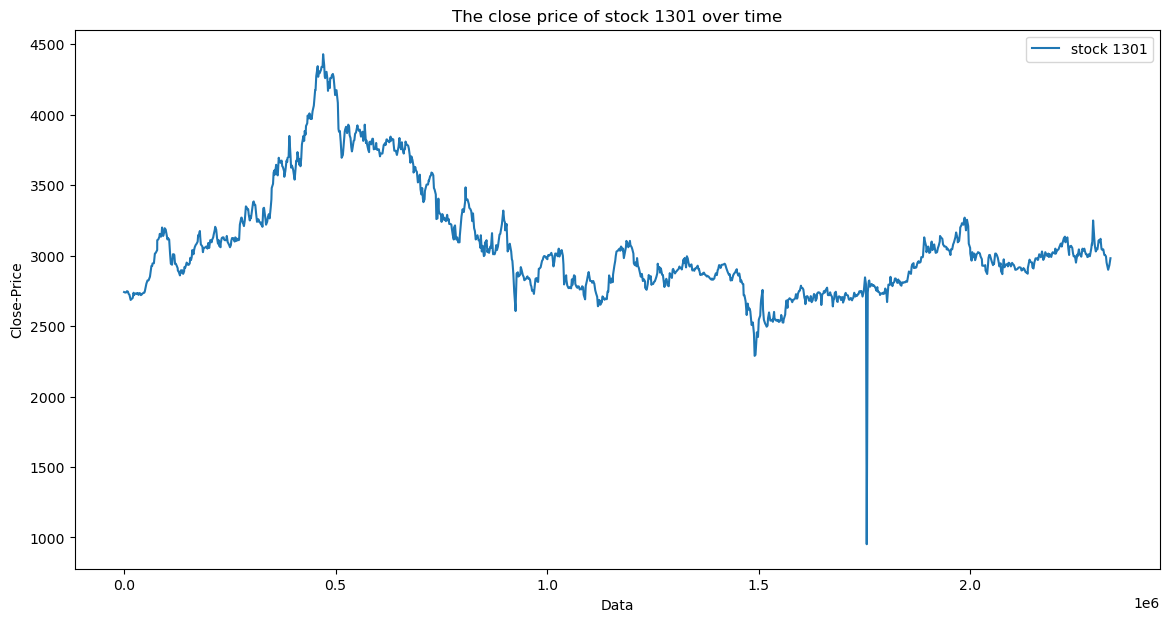

In [7]:
#画图
pd.to_datetime(signle_stock['Date']).to_numpy()
plt.figure(figsize=(14,7))
plt.plot(signle_stock['Close'],label='stock 1301')
plt.xlabel('Data')
plt.ylabel('Close-Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

- **训练集与测试集分割**

In [8]:
#不能改变时间顺序，因此没有使用train_test_split等操作
train_size = int(len(signle_stock) * 0.67)
test_size = len(signle_stock) - train_size
train, test = signle_stock[:train_size], signle_stock[train_size:]

In [9]:
print(train.shape)
train.head()

(805, 10)


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730
2918,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,0,0.002920
5369,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,0,-0.001092
6714,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,0,-0.005100
9073,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,0,-0.003295


In [10]:
train.columns[0]

'Date'

In [16]:
#利用特征法进行数据滑窗处理
#数据预处理,填补缺失值
train=train.fillna(0)
def create_multivariate_dataset(dataset,window_size):
    """
    讲多变量时间序列转化为能够被LSTM训练和预测的数据【特征法】
    参数：
        dataset:DataFrame,包含特征标签,针对此数据,特征滑窗从索引2开始,最后一列是
        window_size:滑窗窗口的大小
    """
    X,y=[],[]
    for i in range(len(dataset)-window_size):
        #.values讲DataFrame转为numpy数组
        #特征滑窗从索引2开始
        feature=dataset.iloc[i:i+window_size,2:-1].values
        target=dataset.iloc[i+window_size-1,-1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(np.array(X,dtype=np.float32)),torch.FloatTensor(y)

In [ ]:
X_train,y_train= create_multivariate_dataset(train,2)
X_train[:5]

In [ ]:
X_train.shape
y_train[:10]

tensor([ 0.0029, -0.0011, -0.0051, -0.0033, -0.0066, -0.0067,  0.0030,  0.0019,
         0.0141, -0.0062])

In [ ]:
#带标签的数据滑窗处理(上一个时间步的结果会对下一个时间步的结果产生影响)：更加适合股价预测


In [ ]:
# Convert data into Tensors
train_tensor = torch.FloatTensor(train).view(-1, train.shape[0], 1)
test_tensor = torch.FloatTensor(test).view(-1, test.shape[0], 1)

In [ ]:
train_tensor.shape

torch.Size([1, 805, 1])

In [ ]:
test_tensor.shape

torch.Size([1, 397, 1])

- **定义网络架构**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=True)

        #输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #初始化h0和c0
        h0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        #LSTM的向前传播，此时我们关注的是所有时间步上的输出，还是最后一个时间步上的输出？
        #所有时间步上的输出，因此我们要输出的是output，而不是hn和cn
        output, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))

        #output的结构为[batch_size, seq_len, hidden_size]
        #因此我们要取出对我们有用的维度
        out = self.fc(output[:, :, :])
        return out

In [ ]:
model = LSTMModel() #实例化
model(train_tensor).shape #尝试查看输出数据的结构

torch.Size([1, 805, 1])

- **损失要多少才算合理？**

In [ ]:
def MSE(Y_ture,Y_predict):
    return ((Y_ture - Y_predict)**2).sum()/Y_ture.shape[0]

如果不使用神经网络预测，只将均值当做预测标签计算MSE的话——

In [ ]:
MSE(train,train.mean())

181625.20248447204

In [ ]:
MSE(test,test.mean())

35148.75818639799

- **第一轮超参数设置与架构设置**

In [ ]:
#超参数设置
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
learning_rate = 0.01
num_epochs = 300

#实例化模型
model1 = LSTMModel(input_size, hidden_size, num_layers, output_size)

#定义损失函数与优化算法
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

#开始进行训练的循环
for epoch in range(num_epochs):
    outputs = model1(train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor[:, :, :])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("训练完成")

Epoch [50/300], Loss: 10208146.0000
Epoch [100/300], Loss: 10165716.0000
Epoch [150/300], Loss: 10129233.0000
Epoch [200/300], Loss: 10094029.0000
Epoch [250/300], Loss: 10048600.0000
Epoch [300/300], Loss: 10000588.0000
训练完成


In [ ]:
model1.eval()
test_outputs = model1(test_tensor).detach().numpy()
MSE(test,test_outputs)

8168489.914357683

从上述训练结果中，不难发现以下问题：

1. **初始损失非常高**，可能说明模型学习能力或初始化技巧有很大的问题

2. **损失下降速度非常缓慢**，说明学习效率和迭代效率有很大问题

3. **迭代次数明显不够**，在300个epoch之后损失是直接使用均值进行预测的30多倍……

4. **测试集上的损失也非常高**，模型处于完全失效的状态

因此，我们可以采取以下的解决方案：

1. **增加LSTM的复杂度**来提升学习能力，现在的LSTM架构过于简单，难以满足当前任务的需求。

2. 如何提升学习效率和迭代效率？**提升学习率**，同时也可以提升batch_size（如果有batch_size的话）。

3. **增加总迭代次数**，给模型更多的训练空间

- **第二轮超参数与架构设置**

In [ ]:
#超参数设置
input_size = 1
hidden_size = 100
num_layers = 5
output_size = 1
learning_rate = 0.1
num_epochs = 1500

#实例化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

#定义损失函数与优化算法
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#开始进行训练的循环
for epoch in range(num_epochs):
    outputs = model(train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor[:, -1, :])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 150 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("训练完成")

Epoch [150/1500], Loss: 3233892.7500
Epoch [300/1500], Loss: 1416913.1250
Epoch [450/1500], Loss: 535400.3125
Epoch [600/1500], Loss: 159067.1250
Epoch [750/1500], Loss: 49066.5977
Epoch [900/1500], Loss: 8391.8633
Epoch [1050/1500], Loss: 677.6950
Epoch [1200/1500], Loss: 293.2071
Epoch [1350/1500], Loss: 246.6494
Epoch [1500/1500], Loss: 287.8425
训练完成


In [ ]:
model.eval()
test_outputs = model(test_tensor).detach().numpy()
MSE(test,test_outputs)

155726.35768261965

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A011.jpg)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A05.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A06.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A09.png)

|||
|:-:|:-:|
|![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A01.png)|![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E8%AF%BE%E7%A8%8B%E5%AE%A3%E4%BC%A07.png)|